In [46]:
!pip install tensorflow opencv-python

In [47]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [48]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [49]:
# Setup paths
POS_PATH = os.path.join('PFA\\data', 'positive')
NEG_PATH = os.path.join('PFA\\data', 'negative')
ANC_PATH = os.path.join('PFA\\data', 'anchor')

In [50]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'PFA\\data\\positive'

In [ ]:
# Database Download Site : http://vis-www.cs.umass.edu/lfw/

In [ ]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
#!tar -xf lfw.tgz

In [ ]:
print(os.getcwd())

In [ ]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir(r'C:\Users\lenovo\PFA\lfw'):
    for file in os.listdir(os.path.join(r'C:\Users\lenovo\PFA\lfw', directory)):
        EX_PATH = os.path.join(r'C:\Users\lenovo\PFA\lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [ ]:
# Import uuid library to generate unique image names
import uuid

In [ ]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

In [57]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

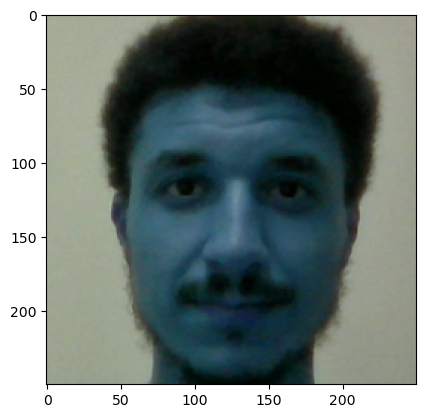

In [58]:
plt.imshow(frame[:250,:250, :])

In [59]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [60]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(3000)

<>:1: SyntaxWarning: invalid escape sequence '\*'
<>:2: SyntaxWarning: invalid escape sequence '\*'
<>:3: SyntaxWarning: invalid escape sequence '\*'
<>:1: SyntaxWarning: invalid escape sequence '\*'
<>:2: SyntaxWarning: invalid escape sequence '\*'
<>:3: SyntaxWarning: invalid escape sequence '\*'
C:\Users\lenovo\AppData\Local\Temp\ipykernel_13828\2360088613.py:1: SyntaxWarning: invalid escape sequence '\*'
  anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(3000)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_13828\2360088613.py:2: SyntaxWarning: invalid escape sequence '\*'
  positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(3000)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_13828\2360088613.py:3: SyntaxWarning: invalid escape sequence '\*'
  negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(3000)


In [61]:
dir_test = anchor.as_numpy_iterator()

In [62]:
print(dir_test.next())

b'PFA\\data\\anchor\\811ca99c-8402-11ef-8f62-00f48da591c1.jpg'


In [63]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [64]:
img = preprocess('PFA\\data\\anchor\\81385ff8-8402-11ef-9d49-00f48da591c1.jpg')

In [65]:
img.numpy().max() 

0.6495098

In [66]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [67]:
samples = data.as_numpy_iterator()

In [68]:
exampple = samples.next()

In [69]:
exampple

(b'PFA\\data\\anchor\\80dc7f1f-8402-11ef-acf0-00f48da591c1.jpg',
 b'PFA\\data\\positive\\aa53212f-8402-11ef-8112-00f48da591c1.jpg',
 1.0)

In [70]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [71]:
res = preprocess_twin(*exampple)

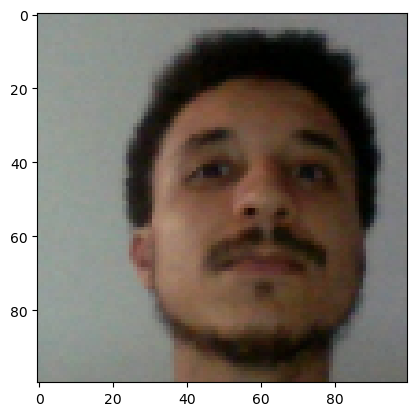

In [72]:
plt.imshow(res[1])

In [73]:
res[2]

1.0

In [74]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [75]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [76]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [77]:
inp = Input(shape=(100,100,3), name='input_image')
c1 = Conv2D(64, (10,10), activation='relu')(inp)
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [78]:
mod.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [79]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [80]:
l1 = L1Dist()

In [81]:
# Importation des modules nécessaires
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from tensorflow.keras.models import Model

# Fonction pour créer la couche de similarité L1
class L1Dist(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(L1Dist, self).__init__(**kwargs)

    def call(self, inputs):
        x, y = inputs
        return tf.abs(x - y)

# Définition des entrées du modèle
input_image = Input(shape=(100, 100, 3), name='input_img')
validation_image = Input(shape=(100, 100, 3), name='validation_img')

# Création de la couche d'embedding
def create_embedding(input_shape):
    model = tf.keras.Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(4096, activation='relu')  # Modification de la taille de la couche Dense pour correspondre à la sortie de l'embedding
    ])
    return model

# Création de la couche d'embedding
embedding = create_embedding(input_shape=(100, 100, 3))

# Application de la couche d'embedding aux images d'entrée
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

# Calcul de la similarité en utilisant la couche L1Dist
distances = L1Dist(name='l1_dist')([inp_embedding, val_embedding])

# Ajout d'une couche dense pour la classification
classifier = Dense(1, activation='sigmoid', name='classifier')(distances)

# Création du modèle SiameseNetwork
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

# Affichage du résumé du modèle
siamese_network.summary()# Importation des modules nécessaires
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from tensorflow.keras.models import Model

# Fonction pour créer la couche de similarité L1
class L1Dist(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(L1Dist, self).__init__(**kwargs)

    def call(self, inputs):
        x, y = inputs
        return tf.abs(x - y)

# Définition des entrées du modèle
input_image = Input(shape=(100, 100, 3), name='input_img')
validation_image = Input(shape=(100, 100, 3), name='validation_img')

# Création de la couche d'embedding
def create_embedding(input_shape):
    model = tf.keras.Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(4096, activation='relu')  # Modification de la taille de la couche Dense pour correspondre à la sortie de l'embedding
    ])
    return model

# Création de la couche d'embedding
embedding = create_embedding(input_shape=(100, 100, 3))

# Application de la couche d'embedding aux images d'entrée
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

# Calcul de la similarité en utilisant la couche L1Dist
distances = L1Dist(name='l1_dist')([inp_embedding, val_embedding])

# Ajout d'une couche dense pour la classification
classifier = Dense(1, activation='sigmoid', name='classifier')(distances)

# Création du modèle SiameseNetwork
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

# Affichage du résumé du modèle
siamese_network.summary()

C:\Users\lenovo\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 4096)      │ 52,526,144 │ input_img[0][0],  │
│ (Sequential)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist (L1Dist)    │ (None, 4096)      │          0 │ sequential[0][0], │
│                     │                   │            │ sequential[1][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier (Dense)  │ (None, 1)         │      4,097 │ l1_dist[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 52,530,241 (200.39 MB)

 Trainable params: 52,530,241 (200.39 MB)

 Non-trainable params: 0 (0.00 B)

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 4096)      │ 52,526,144 │ input_img[0][0],  │
│ (Sequential)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist (L1Dist)    │ (None, 4096)      │          0 │ sequential_1[0][… │
│                     │                   │            │ sequential_1[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier (Dense)  │ (None, 1)         │      4,097 │ l1_dist[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 52,530,241 (200.39 MB)

 Trainable params: 52,530,241 (200.39 MB)

 Non-trainable params: 0 (0.00 B)

In [82]:
def make_siamese_model(): 
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Obtention des embeddings pour les images d'entrée et de validation
    inp_embedding = embedding(input_image)
    val_embedding = embedding(validation_image)
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer([inp_embedding, val_embedding])
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    model = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')
    
    return model

# Construction du modèle Siamese Network
siamese_model = make_siamese_model()

# Affichage du résumé du modèle
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 4096)      │ 52,526,144 │ input_img[0][0],  │
│ (Sequential)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_1 (L1Dist)  │ (None, 4096)      │          0 │ sequential_1[2][… │
│                     │                   │            │ sequential_1[3][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 52,530,241 (200.39 MB)

 Trainable params: 52,530,241 (200.39 MB)

 Non-trainable params: 0 (0.00 B)

In [83]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [84]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [85]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [86]:
test_batch = train_data.as_numpy_iterator()

In [87]:
batch_1 = test_batch.next()

In [88]:
X = batch_1[:2]

In [89]:
y = batch_1[2]

In [90]:
y

array([0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0.],
      dtype=float32)

In [91]:
tf.losses.BinaryCrossentropy??

Init signature:
tf.losses.BinaryCrossentropy(
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction='sum_over_batch_size',
    name='binary_crossentropy',
    dtype=None,
)
Source:        
@keras_export("keras.losses.BinaryCrossentropy")
class BinaryCrossentropy(LossFunctionWrapper):
    """Computes the cross-entropy loss between true labels and predicted labels.

    Use this cross-entropy loss for binary (0 or 1) classification applications.
    The loss function requires the following inputs:

    - `y_true` (true label): This is either 0 or 1.
    - `y_pred` (predicted value): This is the model's prediction, i.e, a single
        floating-point value which either represents a
        [logit](https://en.wikipedia.org/wiki/Logit), (i.e, value in [-inf, inf]
        when `from_logits=True`) or a probability (i.e, value in [0., 1.] when
        `from_logits=False`).

    Args:
        from_logits: Whether to interpret `y_pred` as a tensor of
            [logit](htt

In [92]:
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

In [93]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [94]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [95]:
EPOCHS = 40

In [96]:
train(train_data, EPOCHS)


 Epoch 1/40


C:\Users\lenovo\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_img', 'validation_img']. Received: the structure of inputs=('*', '*')
  warnings.warn(


tf.Tensor(0.70555186, shape=(), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/5 ━━━━━━━━━━━━━━━━━━━━ 1:14 19s/steptf.Tensor(0.50092673, shape=(), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step
2/5 ━━━━━━━━━━━━━━━━━━━━ 26s 9s/step  tf.Tensor(0.5566585, shape=(), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
3/5 ━━━━━━━━━━━━━━━━━━━━ 13s 7s/steptf.Tensor(0.35422593, shape=(), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
4/5 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step tf.Tensor(0.43078613, shape=(), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step
0.43078613 0.0 0.0

 Epoch 2/40
tf.Tensor(0.2882257, shape=(), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/5 ━━━━━━━━━━━━━━━━━━━━ 23s 6s/steptf.Tensor(0.55899704, shape=(), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step
2/5 ━━━━━━━━━━━━━━━━━━━━ 25s 8s/steptf.Tensor(0.33282736, shape=(), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
3/5 ━━━━━━━━━━━━━━━━━━━━ 12s

In [97]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [98]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [99]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


In [100]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]

In [101]:
y_true

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [102]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [103]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [104]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1.0 1.0


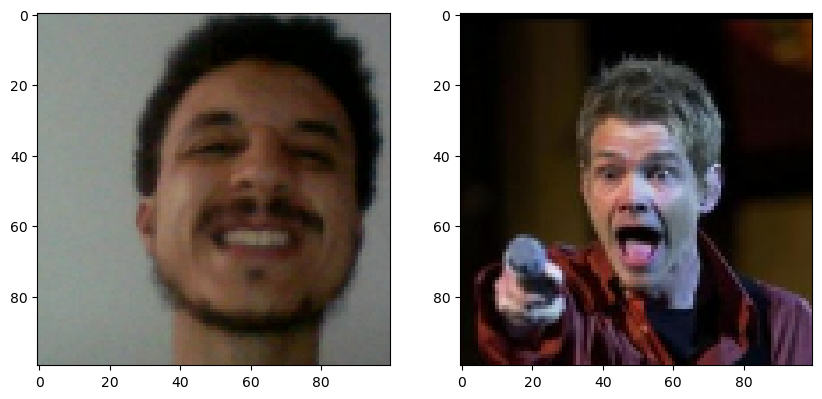

In [105]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[8])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[3])

# Renders cleanly
plt.show()

In [106]:
# Save weights
siamese_model.save('siamesemodel11.h5')

In [107]:
L1Dist

__main__.L1Dist

In [108]:
import tensorflow as tf

# Define your custom layer class
class L1Dist(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(L1Dist, self).__init__(**kwargs)

    def call(self, inputs):
        y_true, y_pred = inputs
        return tf.reduce_sum(tf.abs(y_true - y_pred), axis=-1)


In [109]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'siamesemodelv2.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [110]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step


array([[2.0763387e-07],
       [4.9008033e-12],
       [9.9945265e-01],
       [1.0473493e-08],
       [3.4322923e-08],
       [1.4157986e-04],
       [9.9941438e-01],
       [1.9089335e-09],
       [9.9958211e-01],
       [7.1378931e-04],
       [2.6664981e-08],
       [2.2688990e-10],
       [1.5087864e-09]], dtype=float32)

In [111]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 4096)      │ 52,526,144 │ input_img[0][0],  │
│ (Sequential)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_1 (L1Dist)  │ (None, 4096)      │          0 │ sequential_1[2][… │
│                     │                   │            │ sequential_1[3][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 52,530,241 (200.39 MB)

 Trainable params: 52,530,241 (200.39 MB)

 Non-trainable params: 0 (0.00 B)

In [112]:
os.listdir(os.path.join('PFA\\application_data', 'verification_images'))

['aa397748-8402-11ef-a5d1-00f48da591c1.jpg',
 'aa53212f-8402-11ef-8112-00f48da591c1.jpg',
 'aee7b47d-8402-11ef-a2ac-00f48da591c1.jpg',
 'af06a581-8402-11ef-b4e9-00f48da591c1.jpg',
 'af9450f7-8402-11ef-80cc-00f48da591c1.jpg',
 'b048730e-8402-11ef-af48-00f48da591c1.jpg',
 'b1b7a222-8402-11ef-9b7f-00f48da591c1.jpg',
 'b2527db1-8402-11ef-ba75-00f48da591c1.jpg',
 'b2e0e759-8402-11ef-b993-00f48da591c1.jpg',
 'b3fa351a-8402-11ef-855e-00f48da591c1.jpg',
 'b41138ce-8402-11ef-a169-00f48da591c1.jpg',
 'b4aa4b40-8402-11ef-afc8-00f48da591c1.jpg',
 'ba7ea31c-8402-11ef-b553-00f48da591c1.jpg',
 'd516b6ba-8402-11ef-a013-00f48da591c1.jpg']

In [113]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [114]:
for image in os.listdir(os.path.join('PFA\\application_data', 'verification_images')):
    validation_img = os.path.join('PFA\\application_data', 'verification_images', image)
    print(validation_img)

PFA\application_data\verification_images\aa397748-8402-11ef-a5d1-00f48da591c1.jpg
PFA\application_data\verification_images\aa53212f-8402-11ef-8112-00f48da591c1.jpg
PFA\application_data\verification_images\aee7b47d-8402-11ef-a2ac-00f48da591c1.jpg
PFA\application_data\verification_images\af06a581-8402-11ef-b4e9-00f48da591c1.jpg
PFA\application_data\verification_images\af9450f7-8402-11ef-80cc-00f48da591c1.jpg
PFA\application_data\verification_images\b048730e-8402-11ef-af48-00f48da591c1.jpg
PFA\application_data\verification_images\b1b7a222-8402-11ef-9b7f-00f48da591c1.jpg
PFA\application_data\verification_images\b2527db1-8402-11ef-ba75-00f48da591c1.jpg
PFA\application_data\verification_images\b2e0e759-8402-11ef-b993-00f48da591c1.jpg
PFA\application_data\verification_images\b3fa351a-8402-11ef-855e-00f48da591c1.jpg
PFA\application_data\verification_images\b41138ce-8402-11ef-a169-00f48da591c1.jpg
PFA\application_data\verification_images\b4aa4b40-8402-11ef-afc8-00f48da591c1.jpg
PFA\application_

In [115]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('PFA\\application_data', 'verification_images')):
        input_img = preprocess(os.path.join('PFA\\application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('PFA\\application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [116]:
import cv2
import os
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.9, 0.7)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

NotFoundError: {{function_node __wrapped__ReadFile_device_/job:localhost/replica:0/task:0/device:CPU:0}} NewRandomAccessFile failed to Create/Open: PFA\application_data\input_image\input_image.jpg : The system cannot find the path specified.
; No such process [Op:ReadFile]

In [ ]:
np.sum(np.squeeze(results) > 0.9)

In [ ]:
results